<a href="https://colab.research.google.com/github/cstecker/politicsRLab/blob/main/Analyse%20von%20VAA-Daten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wie die Thesenauswahl den Wahl-O-Mat beeinflusst**
Konzepte und ihre Messung sollten möglichst valide, reliabel und replizierbar sein. Diese Forderung trifft auch auf VAAs zu. Wenn VAAs nur zufällige und stark streuende Empfehlungen aussprechen, wäre dies ein Problem. Walgrave et al. machen darauf aufmerksam, dass die Thesen eine zentrale Zutat für die Berechnung von Ähnlichkeiten durch den VAA sind, die die Berechnung von Ähnlichkeiten zu verschiedenen Parteien maßgeblich beeinflusst.
Welche Kriterien sollten bei der Thesenauswahl berücksichtigt werden? Wie könnte man die Salienzzuschreibung der Parteien berücksichtigen (der Wahl-O-Mat macht das ja nur bei den Wählern) und was spricht dafür, dies zu berücksichtigen?
Wie stark variieren die Ähnlichkeiten zu den Parteien mit der Auswahl der Thesen?
Wir wollen uns dies hier mit Blick auf den Wahl-O-Mat für die hessische Landtagswahl 2023 ansehen. Wie stark variieren die Ähnlichkeiten wenn Thesen herausgelassen werden? Wechseln Parteien sogar ihre Rangordnung?
(Wie gehabt, klicken Sie auf das "play"-Symbol, um die einzelnen Befehle abzufahren.)


## **Setup**
Zu Beginn laden wir die Pakete, die wir benötigen.

In [ ]:
library(tidyverse)

Sodann laden wir die Daten für den Wahl-O-Mat von Hessen, den wir nutzen, um ein paar Überlegungen zu illustrieren

In [ ]:
# Datensatz herunterladen
download.file("https://github.com/cstecker/politicsRLab/blob/main/data/he2023.rds?raw=true", "he2023.rds")

# Datensatz in R einbinden
he2023 <- readRDS("he2023.rds")

**Der Wahl-O-Mat für Hessen 2023**



In [ ]:
glimpse(he2023)

Schließlich können wir auch die oft vertraute "Excel-Perspektive" konsultieren (dazu wählen wir uns mal nur die SPD aus):

In [ ]:
he2023 %>%
    filter(party_short == "SPD") %>%
    View()

# Ihre eigenen Positionen zum Wahl-O-Mat in Hessen 2023

Nun geben Sie ihre Positionen zu den einzelnen Thesen ein (j = "stimme zu", e = "neutral", n = "stimme nicht zu".

In [ ]:
# Creating the tibble with an self_pos column
self_pos <- tribble(
  ~`these_id`, ~`these_title`,                               ~self_pos,
  1,            "Wählen mit 16",                                "n",
  2,            "Abzug der US-Streitkräfte",                    "n",
  3,            "Schulessen",                                   "j",
  4,            "Nachtflugverbot",                              "n",
  5,            "Kohlekraftwerke",                              "j",
  6,            "Abschiebung",                                  "j",
  7,            "Ökologische Landwirtschaft",                   "n",
  8,            "Verfassungsschutz abschaffen",                 "n",
  9,            "Schuldenbremse",                               "j",
  10,           "Verpflichtendes letztes Kita-Jahr",            "j",
  11,           "Landärzte",                                    "j",
  12,           "Bürgergeld",                                   "j",
  13,           "Schiene vor Straße",                           "e",
  14,           "Ausbildungsplatzabgabe",                       "n",
  15,           "Wolf",                                         "j",
  16,           "Geschlechterneutrale Sprache",                 "n",
  17,           "Fünfprozenthürde",                             "j",
  18,           "Sozialwohnungen für Deutsche",                 "j",
  19,           "Bürgerwindparks",                              "j",
  20,           "Mehrgliedriges Schulsystem",                   "j",
  21,           "Hasskriminalität",                             "e",
  22,           "Landespflegegeld",                             "e",
  23,           "Flächenversiegelung",                          "j",
  24,           "Militärische Forschung",                       "j",
  25,           "Familienbild",                                 "j",
  26,           "Grundsteuer",                                  "e",
  27,           "Projekte gegen Rechtsextremismus",             "e",
  28,           "Frauenquote",                                  "n",
  29,           "Abgabe bei Nutzung von Grundwasser",           "e",
  30,           "Zwangsräumungen",                              "j",
  31,           "Paritätische Landeslisten",                    "n",
  32,           "Deutschtest",                                  "j",
  33,           "Strafrechtliche Verfolgung von Sitzblockaden", "j",
  34,           "Volksentscheide",                              "j",
  35,           "Tanzverbot",                                   "j",
  36,           "Entgeltfreier ÖPNV",                           "n",
  37,           "NSU-Akten",                                    "n",
  38,           "Verkaufsoffene Sonntage",                      "j"
) %>%
  # convert positions to numerical scale
  mutate(self_pos = case_when(
    self_pos == "n" ~ -1,
    self_pos == "e" ~ 0,
    self_pos == "j" ~ 1)
    )

In [ ]:
# tibble, das den direkten Vergleich unserer self_pos mit denen der Parteien erlaubt
comparison_data <- self_pos %>% select(these_id, self_pos) %>%
  left_join(he2023, by = "these_id") %>%
  filter(party_short %in% c("CDU", "GRÜNE", "SPD", "AfD", "FDP", "DIE LINKE", "FREIE WÄHLER"))


Sodann berechnen wir die Ähnlichkeitswerte zu den Parteien, wie dies auch der Wahl-O-Mat tut (der Einfachheit halber ohne Gewichtungen)

In [ ]:
# calculate max possible distance
n_theses <- comparison_data %>%  distinct(these_id) %>% count()

# Calculate city block distance
cityblock_scores <- comparison_data %>%
  group_by(party_short) %>%
  # calcualte distance in each issue
  mutate(distance = abs(self_pos - party_pos))

cityblock_scores %>%
  group_by(party_short) %>%
  # calculate total distance and closeness
  mutate(
    total_distance = sum(distance),
    close_perc = 1 - (total_distance / (n_theses*2))) %>%
  distinct(party_short, total_distance, close_perc) %>%
  arrange(desc(close_perc))

  party_short  total_distance close_perc$n
1 CDU          15             0.8026316   
2 AfD          18             0.7631579   
3 FREIE WÄHLER 22             0.7105263   
4 FDP          26             0.6578947   
5 GRÜNE        35             0.5394737   
6 SPD          39             0.4868421   
7 DIE LINKE    59             0.2236842   

In [ ]:
# add other matching algorithms and put it all in one tibble
similarity_scores <- comparison_data %>%
  group_by(party_short) %>%
  mutate(
    cityblock_distance = abs(self_pos - party_pos),
    euclidean_dist = (self_pos - party_pos)^2,
    scalar_product = self_pos * party_pos
  ) %>%
  summarise(
    total_distance = sum(cityblock_distance),
    close_perc = 1 - (total_distance / (n_theses * 2)),
    total_euclidean = sqrt(sum(euclidean_dist)),
    euclidean_perc = 1 - (total_euclidean / sqrt(n_theses * 2^2)),
    sum_scalar_product = sum(scalar_product),
    scalar_perc = sum_scalar_product / n_theses
  ) %>%
  mutate(
    hybrid_score = (close_perc + euclidean_perc + scalar_perc) / 3
  ) %>%
  arrange(desc(hybrid_score))

similarity_scores

Wie verändern sich die Werte, wenn wir zufällig Thesen herauslassen? Dazu simulieren wir verschiedene VAAs (auf Basis unser obigen Präferenzeingabe), indem wir jeweils eine bestimmte Anzahl Thesen herauslassen.

In [ ]:
# Simulation --------------------------------------------------------------

# Prompt to ChatGPT: I now want to run a simulation, where we leave out theses and recalculate the measures.
# The number of theses to be randomly left out should be eligible to change. That's great but can you change
# the code so it stores an id for the specific run and alongside all values that are calculated? Please also
# provide code for a plot that shows how close_perc varies across runs

# Function to simulate leaving out random theses and recalculating similarity measures with run IDs
run_simulation_with_id <- function(comparison_data, n_leave_out, n_repeats = 100) {
  results <- vector("list", n_repeats)

  for (i in 1:n_repeats) {
    # Sample these_id to leave out
    these_to_leave_out <- sample(unique(comparison_data$these_id), size = n_leave_out)

    # Filter out these random theses
    reduced_data <- comparison_data %>%
      filter(!these_id %in% these_to_leave_out)

    # Recalculate similarity measures
    similarity_scores <- reduced_data %>%
      group_by(party_short) %>%
      mutate(
        cityblock_distance = abs(self_pos - party_pos),
        euclidean_dist = (self_pos - party_pos)^2,
        scalar_product = self_pos * party_pos
      ) %>%
      summarise(
        total_distance = sum(cityblock_distance),
        close_perc = 1 - (total_distance / (n() * 2)),
        total_euclidean = sqrt(sum(euclidean_dist)),
        euclidean_perc = 1 - (total_euclidean / sqrt(n() * 2^2)),
        sum_scalar_product = sum(scalar_product),
        scalar_perc = sum_scalar_product / n(),
        hybrid_score = (close_perc + euclidean_perc + scalar_perc) / 3
      ) %>%
      mutate(run_id = i)  # Add a run identifier for each simulation

    results[[i]] <- similarity_scores
  }

  # Combine results from all iterations
  final_results <- bind_rows(results) %>%
    arrange(party_short, run_id)

  return(final_results)
}


Verändern Sie den Wert bei `n_leave_out`, um zu bestimmen, wieviele Thesen zufällig rausfliegen sollen.

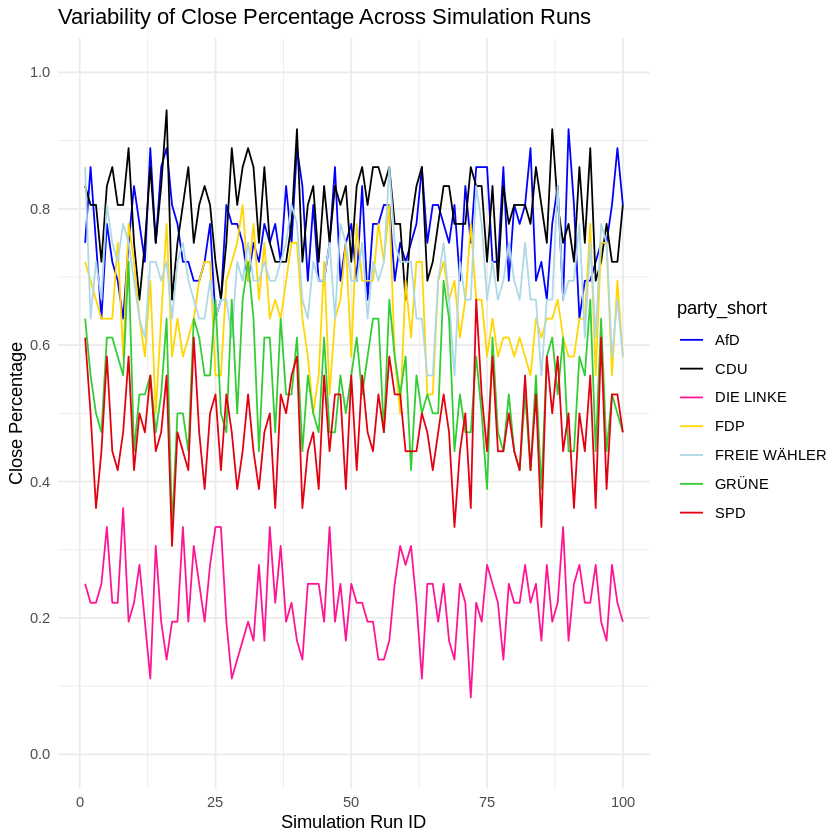

In [ ]:
# Run the simulation
simulated_scores_with_id <- run_simulation_with_id(comparison_data, n_leave_out = 20, 100)

# Plot variability --------------------------------------------------------
party_colors <- c("AfD" = "blue",
                  "GRÜNE" = "#32CD32",
                  "CDU" = "black",
                  "FDP" = "#FFD600",
                  "FREIE WÄHLER" = "lightblue",
                  "DIE LINKE" = "deeppink",
                  "SPD" = "#E3000F")



# Plot showing how close_perc varies across runs for each party
simulated_scores_with_id %>%
  ggplot(aes(x = run_id, y = close_perc, color = party_short, group = party_short)) +
  geom_line() +
  labs(title = "Variability of Close Percentage Across Simulation Runs",
       x = "Simulation Run ID",
       y = "Close Percentage") +
  scale_y_continuous(
    limits = c(0, 1),
    breaks = seq(0, 1, .2)
  ) +
  scale_color_manual(
    values = party_colors
  ) +
  theme_minimal()

Warning message:
“Removed 14 rows containing missing values (`geom_bar()`).”


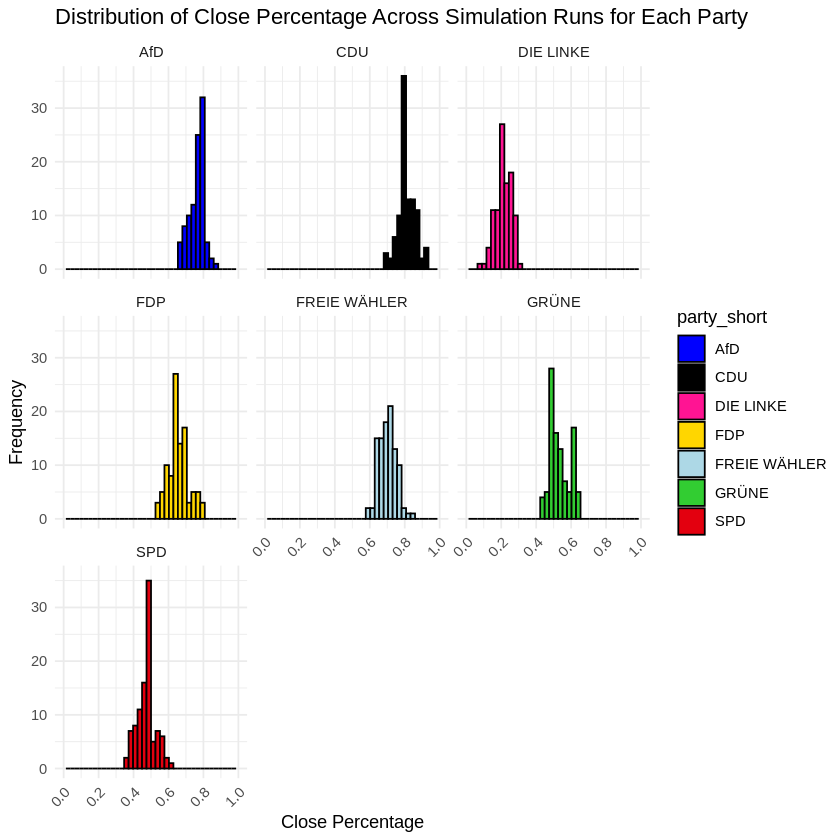

In [ ]:
# histograms for each party
simulated_scores_with_id %>%
  ggplot(aes(x = close_perc, fill = party_short)) +
  geom_histogram(bins = 40, color = "black") +  # Specify the number of bins and boundary color
  facet_wrap(~ party_short, scales = "fixed") +  # Facet by party, allowing different y scales for each
  labs(title = "Distribution of Close Percentage Across Simulation Runs for Each Party",
       x = "Close Percentage",
       y = "Frequency") +
  scale_x_continuous(
    limits = c(0, 1),
    breaks = seq(0, 1, .2)
  ) +
  scale_fill_manual(values = party_colors) +  # Use the same color scheme as the line plot
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
